In [1]:
import sys
sys.path.append("..")

import json

import torch
from torch_geometric.data import DataLoader

from training.model import DRNetwork
from training.dataset import GraphDataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import mplhep as hep
hep.style.use(hep.style.CMS)

import numpy as np

from glob import glob

In [14]:
with open("../config.json") as f:
    config = json.load(f)

# Load the model
models = glob("../output/model*.pt")
best_model = sorted(models, key=lambda x: int(x.split("model_")[1].split(".")[0]))[-1]
print(f"Loading model: {best_model}")
model = DRNetwork().from_config(config=config)
model.load_state_dict(torch.load(best_model, map_location=torch.device("cpu")))

Loading model: ../output/model_200.pt


/tmp/ipykernel_3728975/1983013189.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model, map_location=torch.device("cpu")))


<All keys matched successfully>

In [4]:
dataset = GraphDataset(input_path="../data/", regex="*.pt")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

/home/users/aaarora/.miniforge/envs/ml/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
for graph in dataloader:
    print(graph)
    embedding_orig, labels_orig = model(graph)
    break

DataBatch(x=[2503, 5], edge_index=[2, 940], y=[1330], pair_idxs_left=[1330], pair_idxs_right=[1330], batch=[2503], ptr=[2])


In [6]:
embedding = embedding_orig.detach().numpy()
labels = labels_orig.detach().numpy()

In [7]:
embedding = embedding.reshape(embedding.shape[0] * embedding.shape[1], -1)
labels = np.concatenate([labels, labels], axis=0)

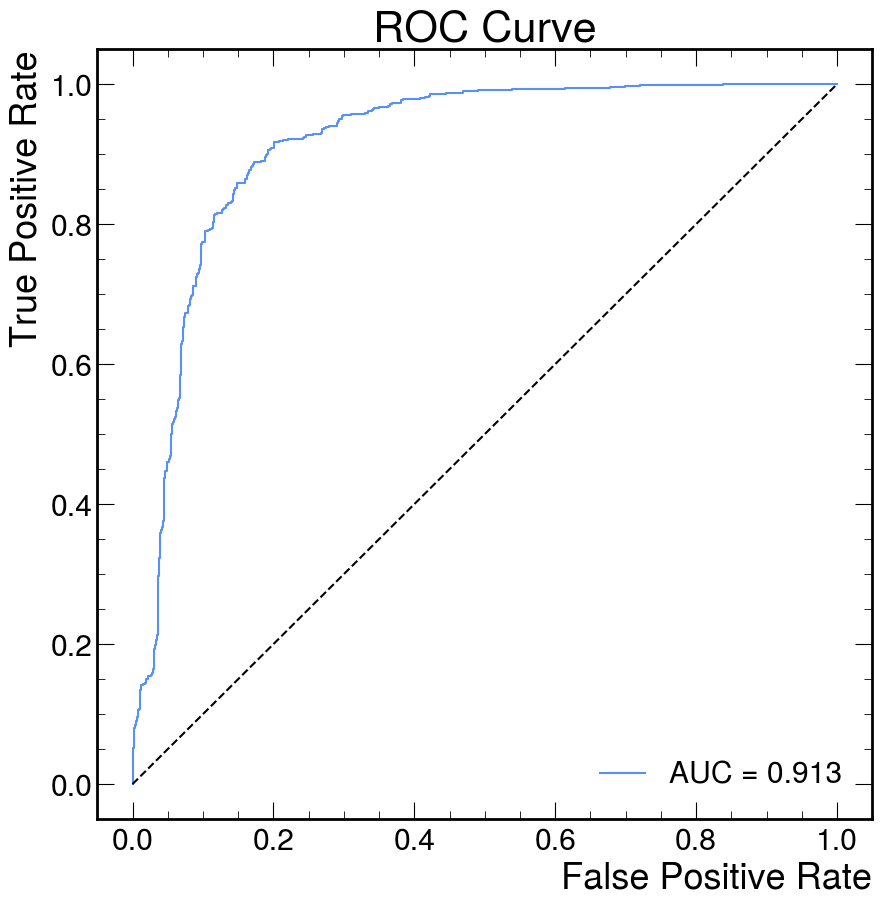

In [8]:
pair_emb = embedding_orig.detach().numpy()
labelroc = labels_orig.detach().numpy()

z1 = pair_emb[0] 
z2 = pair_emb[1] 
dists = np.linalg.norm(z1 - z2, axis=1) 

scores = -dists
fpr, tpr, _= roc_curve(labelroc, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

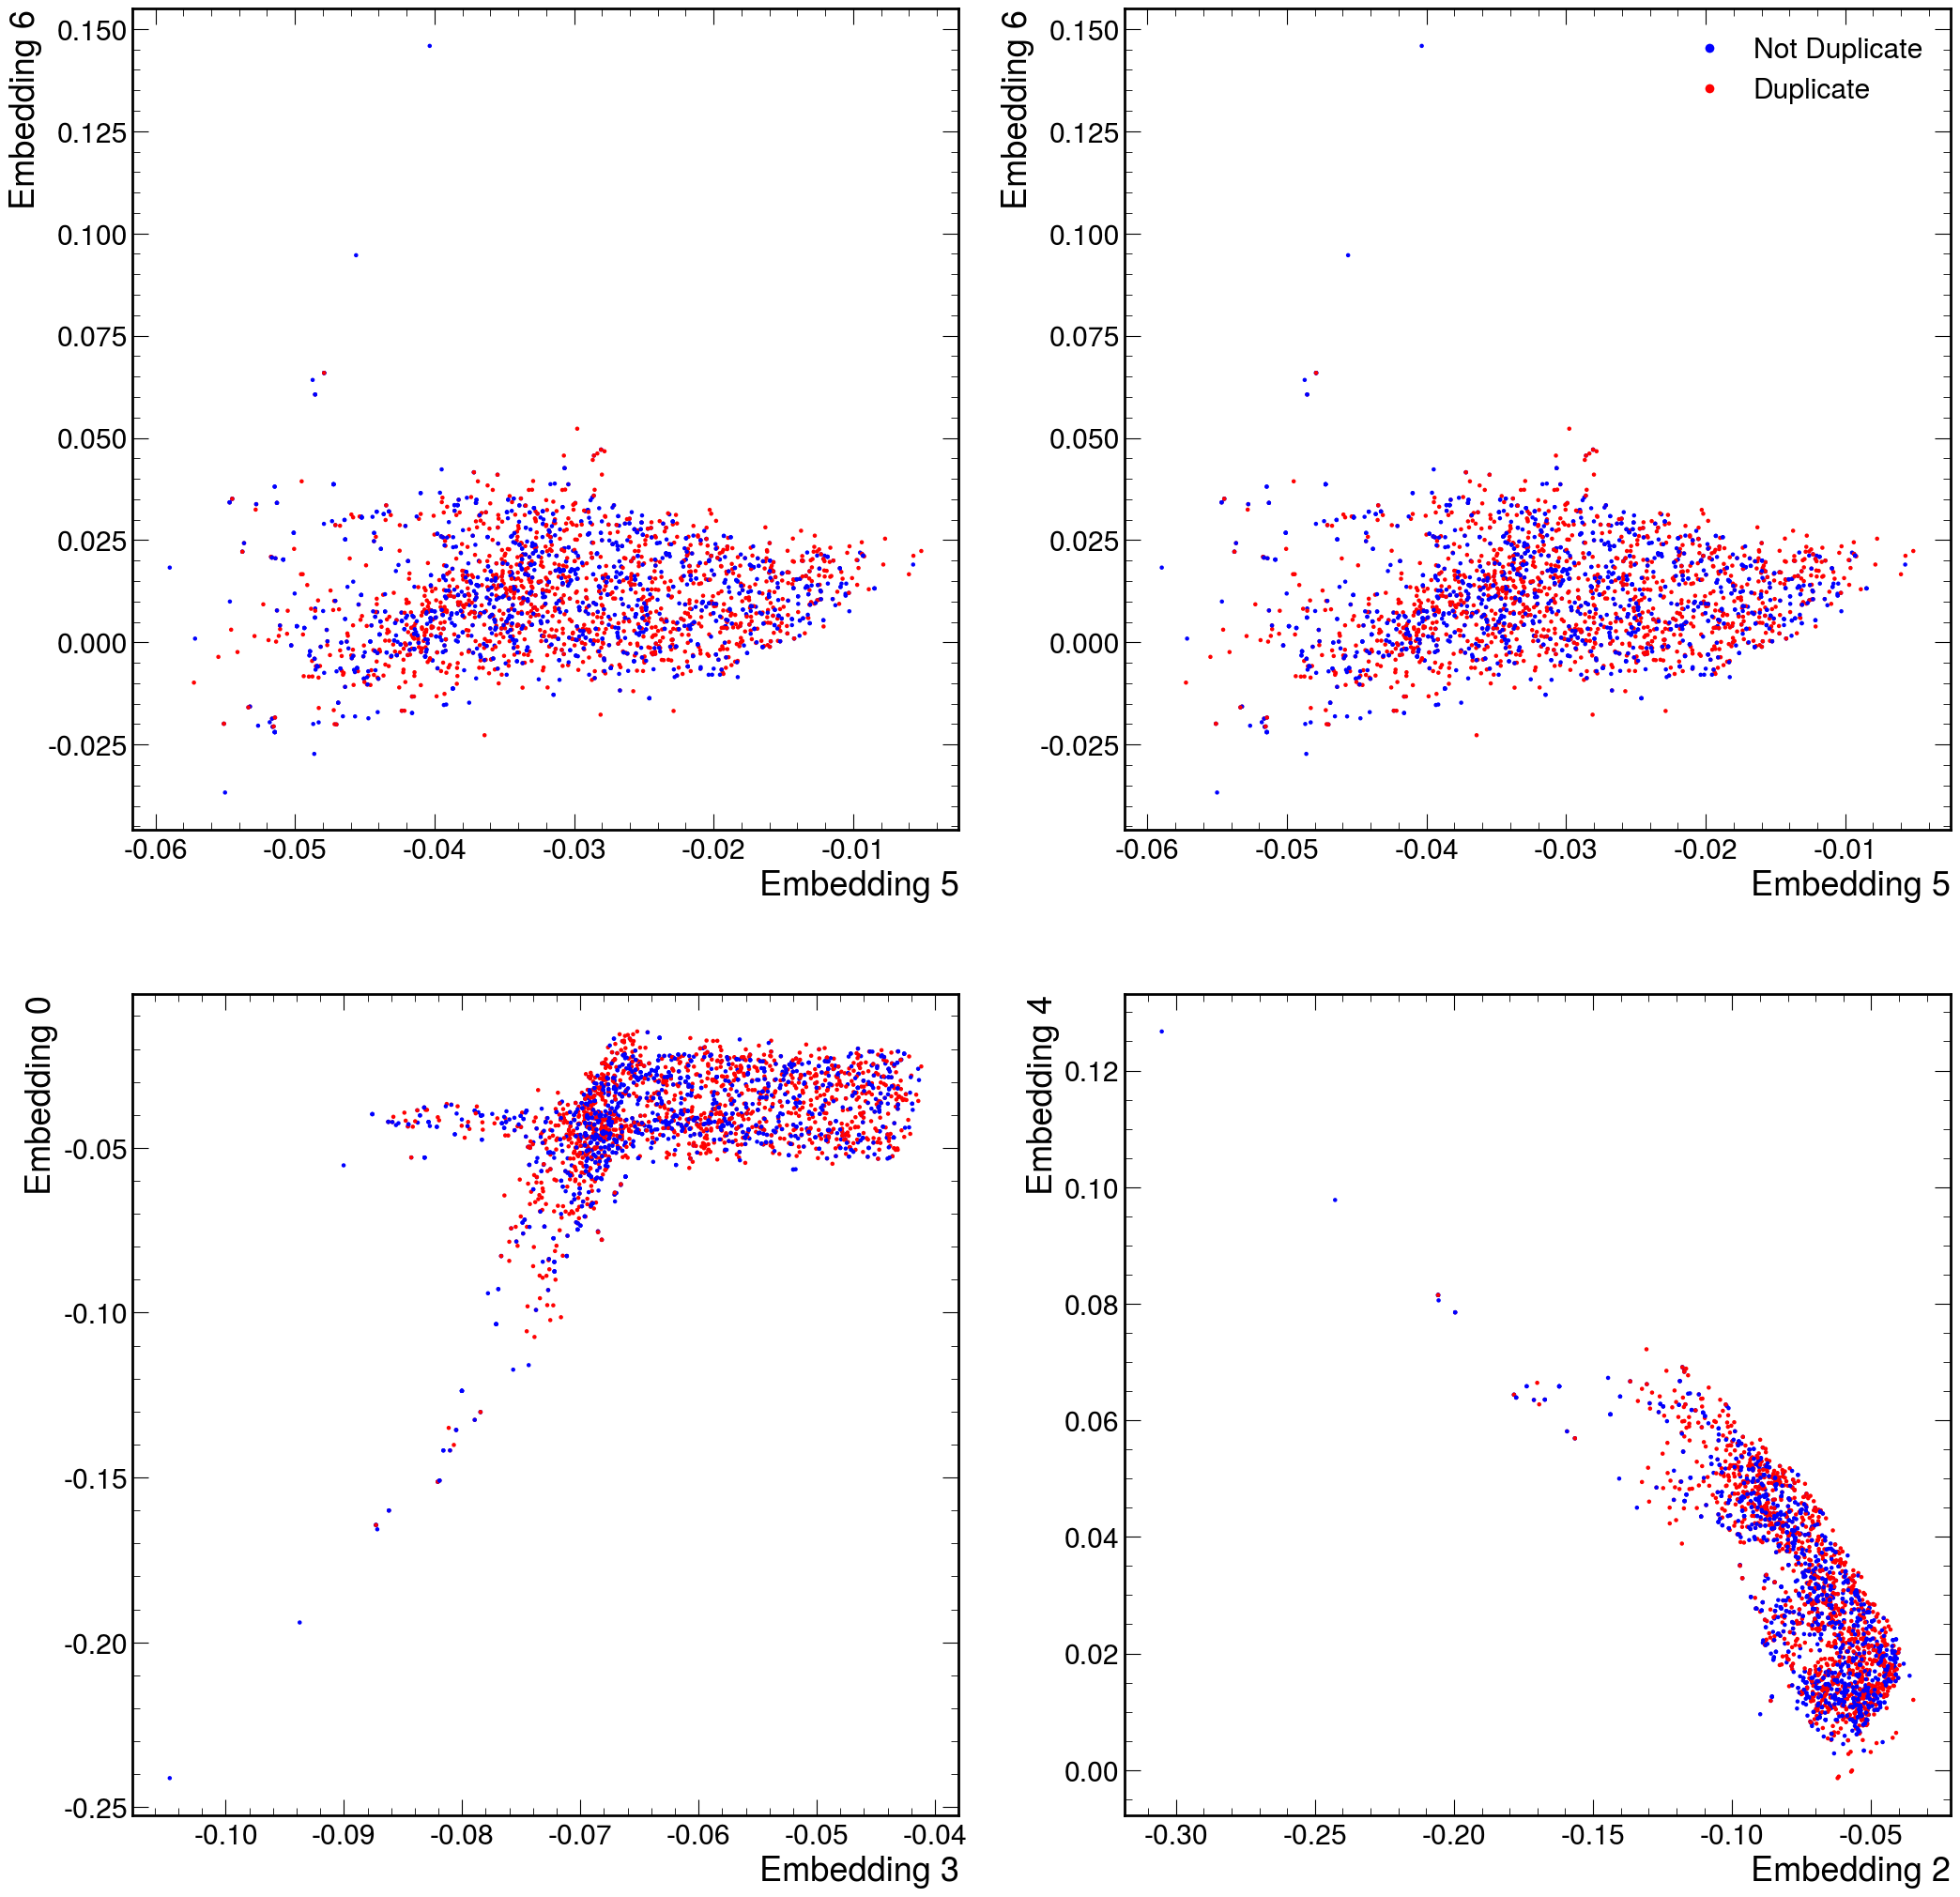

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(25, 25))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        dim1 = np.random.choice(embedding.shape[1])
        dim2 = np.random.choice(embedding.shape[1])
        while dim1 == dim2:
            dim2 = np.random.choice(embedding.shape[1])
        axs[i, j].scatter(embedding[:, dim1], embedding[:, dim2], c=labels, s=5, cmap="bwr")
        axs[i, j].set_xlabel(f"Embedding {dim1}")
        axs[i, j].set_ylabel(f"Embedding {dim2}")

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Not Duplicate', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Duplicate', markerfacecolor='red', markersize=8)
]
axs[0, len(axs[0])-1].legend(handles=handles, loc='upper right')

In [10]:
# do PCA on the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding)

Text(0, 1, 'PCA 2')

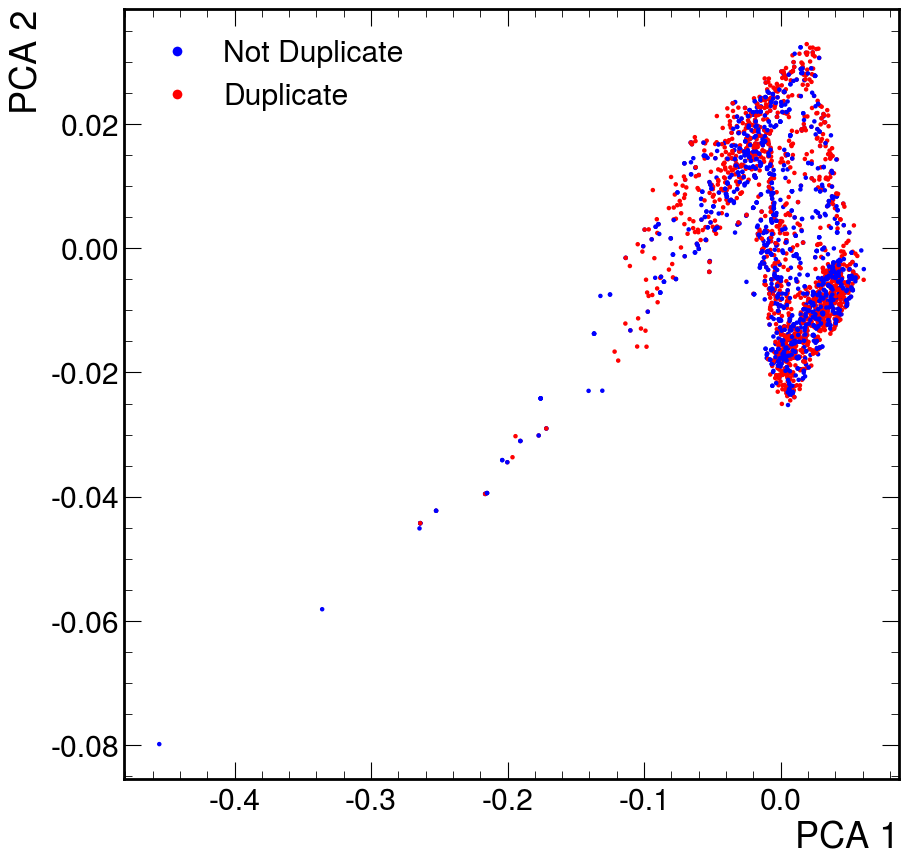

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(embedding_pca[:, 0], embedding_pca[:, 1], s=5, c=labels, cmap="bwr")
handles = [
	plt.Line2D([0], [0], marker='o', color='w', label='Not Duplicate', markerfacecolor='blue', markersize=8),
	plt.Line2D([0], [0], marker='o', color='w', label='Duplicate', markerfacecolor='red', markersize=8)
]
ax.legend(handles=handles)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

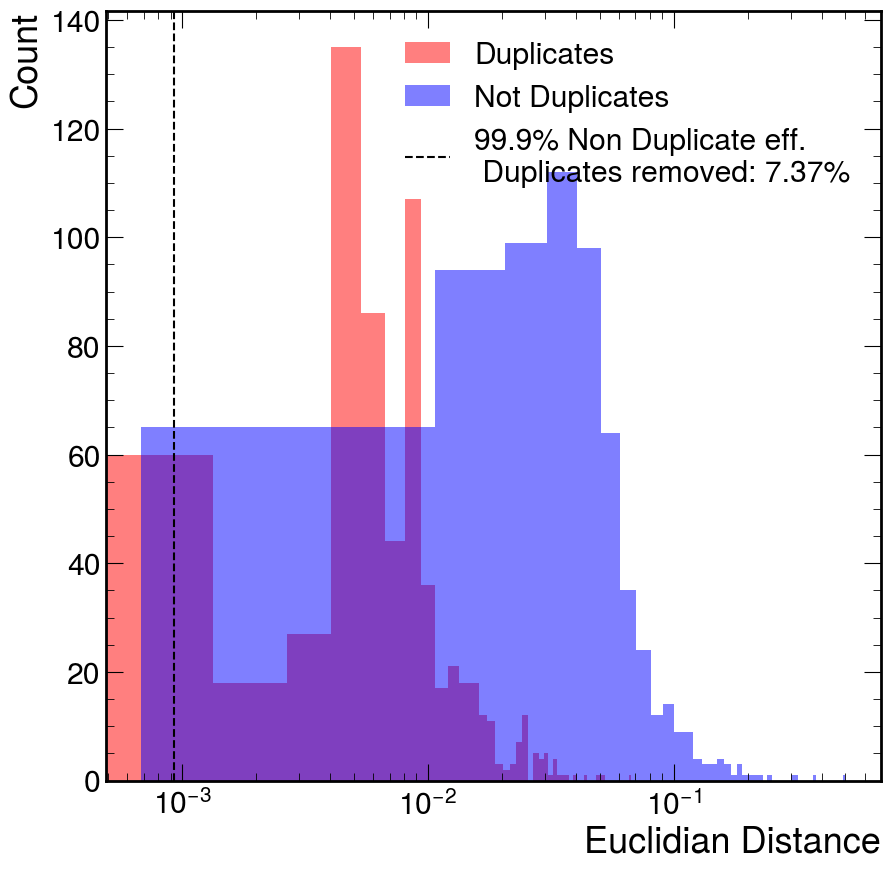

In [13]:
distances_dups = (torch.sqrt(torch.sum((embedding_orig[0] - embedding_orig[1]) ** 2, dim=-1))[labels_orig == 1]).detach().numpy()
distances_nodups = (torch.sqrt(torch.sum((embedding_orig[0] - embedding_orig[1]) ** 2, dim=-1))[labels_orig == 0]).detach().numpy()
plt.hist(distances_dups, bins=50, alpha=0.5, label="Duplicates", color="red")
plt.hist(distances_nodups, bins=50, alpha=0.5, label="Not Duplicates", color="blue")
threshold = np.percentile(distances_nodups, 0.1)
plt.axvline(threshold, color="black", linestyle="--", label=f"99.9% Non Duplicate eff. \n Duplicates removed: {np.round(np.sum(distances_dups < threshold) / len(distances_dups) * 100, 2)}%")

plt.xscale("log")

plt.xlabel("Euclidian Distance")
plt.ylabel("Count")
plt.legend()
plt.show()